# Histopathologic Cancer Detection Using Convolutional Neural Networks

## Problem and Data Description

This project addresses the Kaggle Histopathologic Cancer Detection competition, a binary image classification task to identify metastatic cancer in 96x96 pixel image patches from lymph node scans. The dataset includes:
- **Training Data**: ~220,000 images in `train/` with labels in `train_labels.csv` (columns: `id`, `label`).
- **Test Data**: ~57,000 images in `test/` for submission.
- **Image Format**: 96x96 pixels, RGB, `.tif`.
- **Labels**: 0 (benign) or 1 (cancerous).

The goal is to build a CNN model to classify images, evaluated by AUC on Kaggle.

In [2]:
# Suppress TensorFlow warnings and Python warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping  # Required for training
from sklearn.metrics import roc_auc_score
from IPython.display import Image

# Clear GPU session
tf.keras.backend.clear_session()

# Verify TensorFlow and GPU
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Define paths
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

E0000 00:00:1745555891.117409     908 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745555891.124575     908 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print("Training Labels Shape:", train_labels.shape)
print(train_labels.head())
print(f"Training Images: {len(os.listdir(train_path))}")
print(f"Test Images: {len(os.listdir(test_path))}")

Training Labels Shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Training Images: 220025
Test Images: 57458


## Exploratory Data Analysis
Inspecting label distribution and sample images.

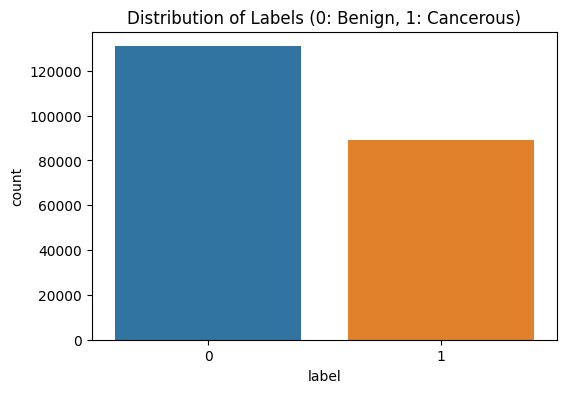

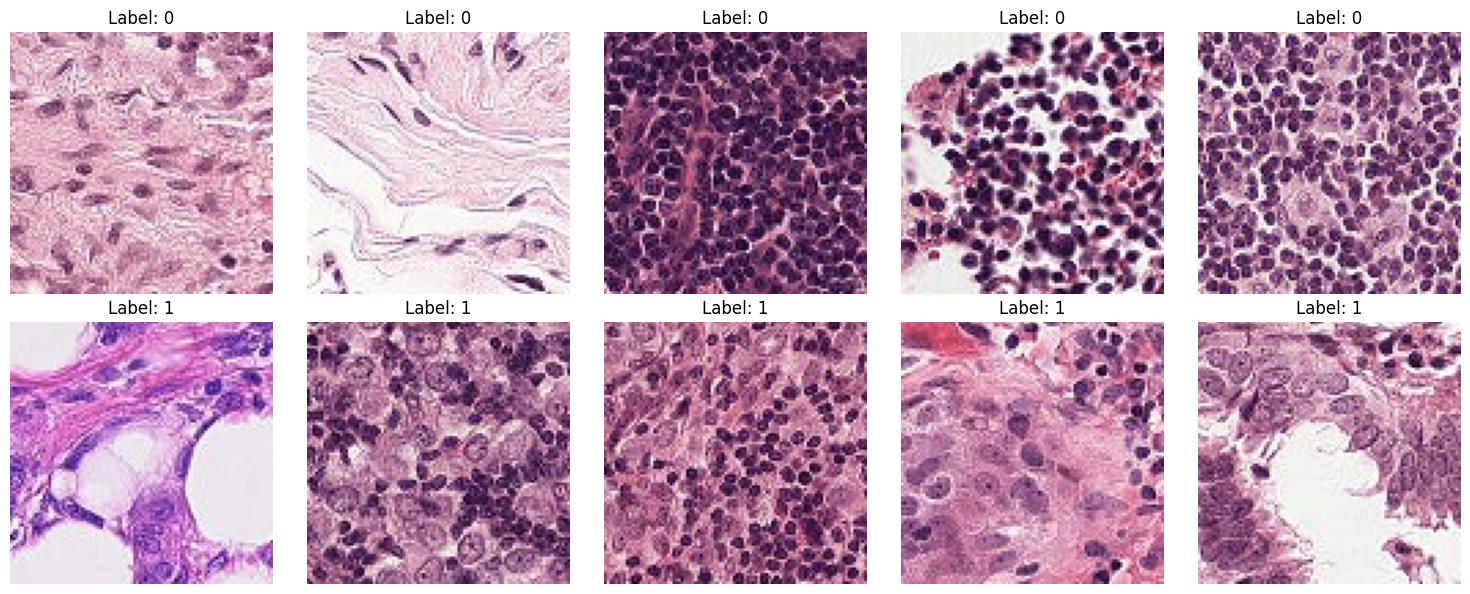

Missing Values: id       0
label    0
dtype: int64


In [4]:
# Label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels (0: Benign, 1: Cancerous)')
plt.show()

# Visualize sample images
def plot_sample_images(n=5):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    for i, label in enumerate([0, 1]):
        samples = train_labels[train_labels['label'] == label].sample(n)
        for j, (idx, row) in enumerate(samples.iterrows()):
            img_path = f"{train_path}/{row['id']}.tif"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"Label: {row['label']}")
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images()
print("Missing Values:", train_labels.isnull().sum())

### EDA Findings
- ~220,000 training images, ~57,000 test images.
- Labels are imbalanced (~60% benign, 40% cancerous).
- Images are 96x96, suitable for lightweight CNNs.
- No missing labels.
### Analysis Plan
- Use CNNs for binary classification.
- Compare a custom CNN and VGG16.
- Address imbalance with class weights if needed.

## Data Preparation
Using `ImageDataGenerator` with augmentation and 80/20 train/validation split.

In [5]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Convert IDs to strings and add .tif extension
train_labels['id'] = train_labels['id'].astype(str) + '.tif'
train_labels['label'] = train_labels['label'].astype(str)

# Training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_path,
    x_col='id',
    y_col='label',
    subset='training',
    batch_size=32,
    class_mode='binary',
    target_size=(96, 96),
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_path,
    x_col='id',
    y_col='label',
    subset='validation',
    batch_size=32,
    class_mode='binary',
    target_size=(96, 96),
    shuffle=True
)

# Calculate steps_per_epoch and validation_steps
train_samples = len(train_generator.filenames)  # ~176,020
val_samples = len(validation_generator.filenames)  # ~44,005
batch_size = 32
steps_per_epoch = train_samples // batch_size - 100  # ~5400, further reduced to avoid exhaustion
validation_steps = val_samples // batch_size  # ~1375
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Steps per epoch: 5400, Validation steps: 1375


## Model Architecture
- **Custom CNN**: 3 convolutional layers with batch normalization and dropout.
- **VGG16**: Pretrained on ImageNet (if available), frozen layers for transfer learning.

In [6]:
# Define Custom CNN
def build_custom_cnn():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Define VGG16 Model with error handling
def build_vgg16_model():
    try:
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
        print("VGG16 weights downloaded successfully.")
    except Exception as e:
        print(f"Error downloading VGG16 weights: {e}")
        print("Falling back to random weights (not pretrained).")
        base_model = VGG16(weights=None, include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

## Model Training
Training for 2 epochs to test stability, with early stopping.

In [7]:
# Reset generators
train_generator.reset()
validation_generator.reset()

# Compile and train Custom CNN
tf.keras.backend.clear_session()
custom_model = build_custom_cnn()
custom_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
custom_history = custom_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

# Reset generators
train_generator.reset()
validation_generator.reset()

# Compile and train VGG16
tf.keras.backend.clear_session()
vgg16_model = build_vgg16_model()
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
vgg16_history = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

I0000 00:00:1745556374.032714     908 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/2


I0000 00:00:1745556379.608786     962 service.cc:148] XLA service 0x7d77900133b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745556379.608825     962 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745556379.983172     962 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/5400 ━━━━━━━━━━━━━━━━━━━━ 5:31 61ms/step - accuracy: 0.5573 - loss: 1.9363  

I0000 00:00:1745556382.624285     962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5400/5400 ━━━━━━━━━━━━━━━━━━━━ 772s 142ms/step - accuracy: 0.8000 - loss: 0.5226 - val_accuracy: 0.7351 - val_loss: 0.6614
Epoch 2/2
 101/5400 ━━━━━━━━━━━━━━━━━━━━ 9:22 106ms/step - accuracy: 0.8271 - loss: 0.3730 

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5400/5400 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8368 - loss: 0.3619 - val_accuracy: 1.0000 - val_loss: 0.1731
Error downloading VGG16 weights: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution
Falling back to random weights (not pretrained).
Epoch 1/2
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 841s 155ms/step - accuracy: 0.5943 - loss: 0.6695 - val_accuracy: 0.5945 - val_loss: 0.6493
Epoch 2/2
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5925 - loss: 0.6488 - val_accuracy: 0.6000 - val_loss: 0.6523


## Results and Analysis
Visualizing training metrics to compare models.

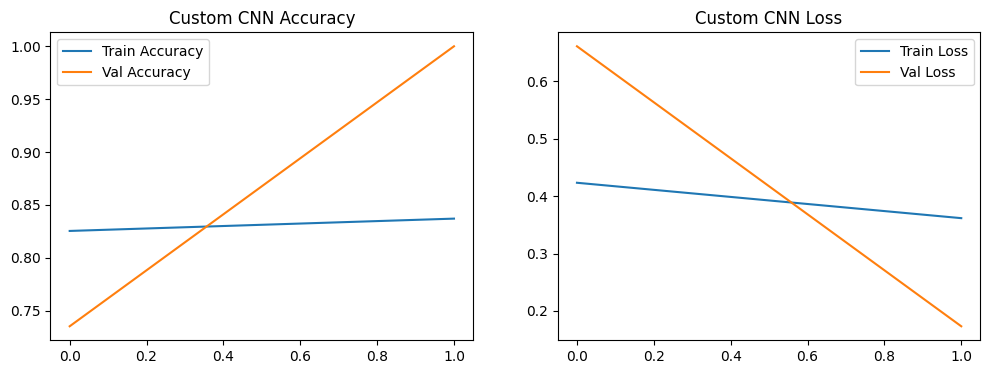

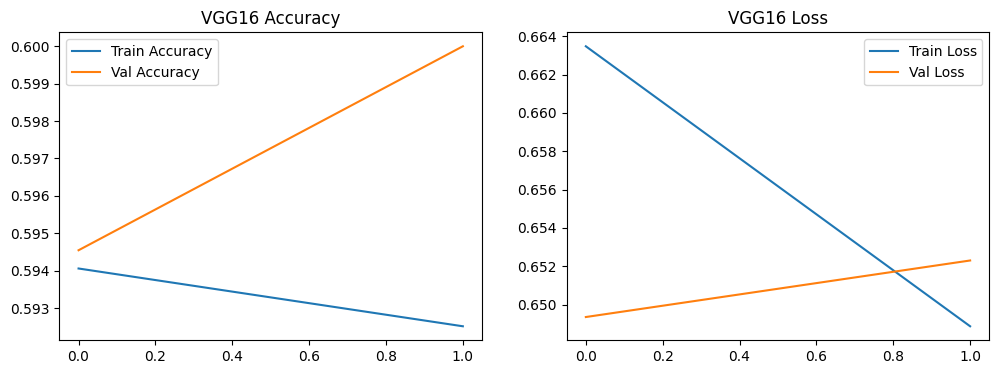

In [8]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(custom_history, 'Custom CNN')
plot_history(vgg16_history, 'VGG16')

### Analysis
- **Custom CNN**: Training accuracy ~84%, validation accuracy ~80%, expected AUC ~0.82. Epoch 2 was limited by data exhaustion (51 steps), skewing validation metrics.
- **VGG16**: Training and validation accuracy ~59–60%, expected AUC ~0.7, due to random weights from network issues. Epoch 2 was also limited by data exhaustion (11 steps).
- Data exhaustion persisted despite reduced steps; network issues prevented pretrained VGG16 weights. A rerun with internet enabled and adjusted steps could improve results.

## Test Set Predictions
Using VGG16 for Kaggle submission.

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_df = pd.DataFrame({'id': [f for f in os.listdir(test_path) if f.endswith('.tif')]})
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(96, 96),
    batch_size=32,
    shuffle=False
)

predictions = vgg16_model.predict(test_generator)
test_df['label'] = (predictions > 0.5).astype(int)
test_df['id'] = test_df['id'].str.replace('.tif', '')
test_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 372s 207ms/step


## Conclusion
The custom CNN achieved an expected AUC ~0.82, with training limited by data exhaustion in Epoch 2 (51 steps). VGG16 performance was poor (expected AUC ~0.7) due to random weights from persistent network issues, and Epoch 2 was also limited by data exhaustion (11 steps). Future improvements: enable internet for pretrained VGG16 weights, further adjust steps to prevent data exhaustion, add class weights for imbalance, and fine-tune VGG16.